# TMA4320 - Industriell Matematikk

__INTRODUCTION__

The standard amount of RAM for an average desktop computer is about 8 GB, though 16 GB and  32 GB also are normal RAM sizes (Witman, 2021). For most programmers this is more than enough memory, and a problem will not arise until one wishes to save/store large amounts of data. As a computer has limited memory, we will not be able to store infinite amouts of data. To ensure that we use our memory space as effectively as possible, there is a couple of tricks we may use. In this project we are going to study how to effectively store data using a method called the NMF, Non-negative Matrix factorization. We are going to use this method to store the data from a dataset called CryptoPunks. Futhermore we are going to study how good this method is by comparing the orignal data, with the data we get by reconstructing the data store with the NMF method. Another benefit with the NMF method is its ability to denoise pictures. To conclude will the NMF method both save space and denoise our pictures. 

In [124]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 

import os
import time

Our goal in this project is to minimize the memory used to store information with respect to arrays. We wish to accomplish this by storing the information for a matrix $A$ in two smaller matrices $H$ and $W$. These matrices will contain the essence of the information presented in matrix $A$, although the information will not be identical. The relationship between these matrices is defined by the following equation: 
$$ A \approx WH$$
The algorithm we are going to use is a multiplicative rule proposed by Lee and Seung. Here the iterates of $H_k$ and $W_k$ are defined by:

$$H_{k+1} = H_k \odot (W_k^TA)\oslash(W_k^TW_kH_k)$$
$$ $$
$$W_{k+1} = W_k \odot (AH_{k+1}^T)\oslash(W_kH_{k+1}H_{k+1}^T)$$


Lets now assume that A is a non-negative matrix and that the initial matrices $W_0$ and $H_0$ are positive. This implies that none of the elements in the matrices are negative. We know that a non-negative number multiplied or divided by another non-negative number always is non-negative, given that the divisor does not equal 0. We can avoid zerodivision by adding a safty division term $\delta$. The same rule goes for addition, a non-negative number plus another non-negative number is always non-negative. With this in mind we can conclude that when two non-negative numbers interact with one of the given operators, the result will always be non-negative. Since the definitions of the iterates of H and W only are defined using only the named operators, we can conclude that all the iterates will be non-negative. 

We know every element in $A$ is non-negative, and every element in $H_0$ and $W_0$ are positive. The same goes for all the elements in $H_0^T$ and $W_0^T$. With this knowledge we are able to calculate $H_1$ and $W_1$. Based on the reasoning above, they will both have to be positive. 

$$H_1 = H_0 \odot (W_0^TA) \oslash (W_0^TW_0H_0) = positive \cdot (positive) \div (positive) = positive$$

$$W_1 = W_0 \odot (AH_1^T) \oslash (W_0H_1H_0^T) = positive \cdot (positive) \div (positive) = positive$$

If we assume that $H_{n-1}$ and $W_{n-1}$ is positive, we get the iterates
$$H_n = H_{n-1} \odot (W_{n-1}^TA) \oslash (W_{n-1}^TW_{n-1}H_{n-1}) = positive \cdot (positive) \div (positive) = positive$$

$$W_n = W_{n-1} \odot (AH_n^T) \oslash (W_{n-1}H_nH_n^T) = positive \cdot (positive) \div (positive) = positive$$

Thus we have shown that all iterates have to be positive.

In the situation where $(W_k^TA)\oslash(W_k^TW_kH_k)$ is equal to a matrix of ones, $H_{k+1} = H_{k}$. Seen as $\odot$ is the operator for elementwise multiplication, multiplying the matrix $H_k$ with a matrix of ones is equivalent to multiplying the matrix with the integer 1. Let 

$$ $$ $$(W_k^TA)\oslash(W_k^TW_kH_k) = \text{matrix of ones}$$

$$\implies W_k^TA = W_k^TW_kH_k$$

We se that $W_k^T$ is a common factor in both of the terms. For the equation to hold this implies that $A = W_kH_k$

If we were to set the initial $W$ and $H$ matrices to matrices containing only zeros, there would be zerodivision in our calculations of the iterates. Say we add a safetydivison term $\delta$ in the divisor, to ensure that there will be no zerodivision, there would still be an issue. Seen as the iterates are defined with multiplication with the intial matrices, the matrices will not develop and stay equal to the zero matrix.

We are now going to investigate the following four matrices: 
    
$$
A_1 = \begin{bmatrix}
    1  &  0      \\
    0  &  1      
\end{bmatrix}
\quad
A_2 = 
\begin{bmatrix}
    1  &  2      \\
    1  &  1      \\
    1  &  2      
\end{bmatrix} 
\quad
A_3 = \begin{bmatrix}
    2  &  1  &  1\\
    2  &  1  &  1\\
    1  &  1  &  2\\   
\end{bmatrix}
\quad
A_4 = 
\begin{bmatrix}
    2  &  1  &  0\\
    1  &  2  &  3\\
    0  &  3  &  3\\ 
\end{bmatrix} 
$$

In [2]:
#Matrices we will investigate, as defined above
A_1 = np.array([[1,0],[0,1]])

A_2 = np.array([[1,2],[1,1], [1,2]])

A_3 = np.array([[2,1,1],[2,1,1],[1,1,2]])

A_4 = np.array([[2,1,0],[1,2,3],[0,3,3]])


In [3]:
def NMF(A, d, delta = 1e-9, maxiter = 1000, seed = 0):
    """
    NMF is a function which decomposes a matrix A into 2 matrices H and W
    It uses Lee and Seungs multiplcative update for calculations of the iterates
    input:
        A: (m,n) input array
        d: integer, Number of components we want to decompose A into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
    """
    # Chooses a random seed if non is given
    if seed != 0:
        np.random.seed(seed)

    rows = len(A)            # number of rows, m
    columns = len(A[0])      # number of columns, n

    # Initializing and scaling W_0, H_0
    uniformNumbersW = np.random.uniform(0.0, 1.0, rows * d ) * np.sqrt(np.mean(A)/d) 
    uniformNumbersH = np.random.uniform(0.0, 1.0, columns * d) * np.sqrt(np.mean(A)/d)

    # Shaping the initialized values into matrices
    W = uniformNumbersW.reshape((rows, d))
    H = uniformNumbersH.reshape((d,columns))

    # Makes an empty list to fill with the norms
    norms = np.zeros(maxiter)
    norms[0] = np.linalg.norm(A-np.dot(W,H), ord = 'fro')
    
    for k in range(1,maxiter):
        WTransformed = W.copy()
        WTransformed = WTransformed.T
        
        #Defines H
        H = np.divide(np.multiply(H,WTransformed @ A),(WTransformed @ W @ H) + delta)

        HTransformed = H.copy()
        HTransformed = HTransformed.T

        # Defines W
        W = np.divide(np.multiply(W,A @ HTransformed),(W @ H @ HTransformed) + delta)
        norms[k] = np.linalg.norm(A-np.dot(W,H), ord = 'fro')

    
    return W, H, norms

In [4]:
W_A1_1, H_A1_1, norms_A1_1 = NMF(A_1, 1, delta = 1e-9, maxiter = 1000, seed = 0)
W_A1_2, H_A1_2, norms_A1_2 = NMF(A_1, 1, delta = 1e-9, maxiter = 1000, seed = 1)

W_A2_1, H_A2_1, norms_A2_1 = NMF(A_2, 1, delta = 1e-9, maxiter = 1000, seed = 0)
W_A2_2, H_A2_2, norms_A2_2 = NMF(A_2, 1, delta = 1e-9, maxiter = 1000, seed = 1)

In [5]:
print("A1, seed = 0: ")
print("W:", W_A1_1)
print("\nH:", H_A1_1)
print("\nWH:",W_A1_1@H_A1_1)
print("\nNorm: ",norms_A1_1[-1])
print("-------------------------------")
print("A1, seed = 1: ")
print("W:", W_A1_2)
print("\nH:", H_A1_2)
print("\nWH:",W_A1_2@H_A1_2)
print("\nNorm: ",norms_A1_2[-1])
print("-------------------------------")

print("A2, seed = 0: ")
print("W:", W_A2_1)
print("\nH:", H_A2_1)
print("\nWH:",W_A2_1@H_A2_1)
print("\nNorm: ",norms_A2_1[-1])
print("-------------------------------")
print("A2, seed = 1: ")
print("W:", W_A2_2)
print("\nH:", H_A2_2)
print("\nWH:",W_A2_2@H_A2_2)
print("\nNorm: ",norms_A2_2[-1])
print("-------------------------------")

A1, seed = 0: 
W: [[0.40411539]
 [0.13206219]]

H: [[2.2357739  0.73063586]]

WH: [[0.90351063 0.29526119]
 [0.29526119 0.09648937]]

Norm:  1.0
-------------------------------
A1, seed = 1: 
W: [[0.29487387]
 [0.50935648]]

H: [[0.85126573 1.47045145]]

WH: [[0.25101602 0.43359772]
 [0.43359772 0.74898398]]

Norm:  1.0
-------------------------------
A2, seed = 0: 
W: [[0.1920358 ]
 [0.11720277]
 [0.1920358 ]]

H: [[ 5.72937474 10.11916655]]

WH: [[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]

Norm:  0.41115460006510873
-------------------------------
A2, seed = 1: 
W: [[0.92125205]
 [0.56225606]
 [0.92125205]]

H: [[1.19429318 2.10934913]]

WH: [[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]

Norm:  0.41115460006510873
-------------------------------



Above is a printout of $H$, $W$ ,$WH$ and the norm of the matrices $A_1$ and $A_2$ for 2 different seeds. Lets first look at the case for the $A_1$ matrix. We observe that $H$ and $W$ are unique for the different seeds, which is logical since the random numbers are chosen based on the seeds. The matrices $WH$ are also unique, though the norms are equal. The matrices $WH$ are an approximation of our initial matrix $A_1$, reconstructed from the matrices $H$ and $W$. From our printout we can conclude that in our case there are at least two matrices which makes a good enough approximation to $A_1$. Seen as their norms are equal, these approximations are equally good. There might be even more matrices $WH$ which makes equally good approximations, but we can neither confirm nor deny this based on our printouts. In respect to matrix $A_2$ the situation is a little bit different. As for the matrix $A_1$ the matrices $W$ and $H$ are unique, though the matrices $WH$ are approximately equal. Seen as the matrices $WH$ are equal, it follows that the norms are so as well. We cannot confirm that there does not exist any other matrices $WH$ that could be a good approximation to $A_2$, though we cannot deny it either. 

In [6]:
W1,H1,norm1 = NMF(A_1, 2, delta = 1e-9, maxiter = 1000, seed = 2)
W2,H2,norm2 = NMF(A_2, 2, delta = 1e-9, maxiter = 1000, seed = 2)

In [7]:
print("A1: ")
print("W:", W1)
print("\nH:", H1)
print("\nWH:",W1@H1)
print("\nNorm: ",norm1[-1])
print("-------------------------------")
print("A2: ")
print("W:", W2)
print("\nH:", H2)
print("\nWH:",W2@H2)
print("\nNorm: ",norm2[-1])
print("-------------------------------")

A1: 
W: [[0.47235567 0.        ]
 [0.         0.29058469]]

H: [[2.1170488  0.        ]
 [0.         3.44133752]]

WH: [[1. 0.]
 [0. 1.]]

Norm:  5.545803510912732e-10
-------------------------------
A2: 
W: [[0.56622869 0.09759042]
 [0.16428959 0.44210825]
 [0.56622869 0.09759042]]

H: [[1.47040519 3.3573272 ]
 [1.71547969 1.01429023]]

WH: [[1. 2.]
 [1. 1.]
 [1. 2.]]

Norm:  9.604534359343324e-10
-------------------------------


Calculating the NMF for $A_1$ and $A_2$ with $d=2$ we get a good approximation to our startmatrices. The norm is significantly smaller than previous calculations where $d=1$. Comparing the norms of the two cases, $A1$ and $A2$, we see that the norm for $A1$ is smaller than the norm for $A2$. The reason for this is that $A_1$ has a definite solution, the same might be the case for $A_2$ though we cannot know for certain. Seen as the norm for $A_2$ is larger than the norm for $A_1$ this might indicate that $WH$ for $A_2$ is in a local minima. 

In [8]:
print("Eigenvalues for A3:")
print(np.linalg.eig(A_3)[0])
print("Eigenverctors for A3")
print(np.linalg.eig(A_3)[1])
print("-------------------------------------------------------------------------------------")
print("Eigenvalues for A4:")
print(np.linalg.eig(A_4)[0])
print("Eigenverctors for A4")
print(np.linalg.eig(A_4)[1])
print("-------------------------------------------------------------------------------------")

Eigenvalues for A3:
[ 4.00000000e+00  1.00000000e+00 -4.04414586e-16]
Eigenverctors for A3
[[ 0.57735027  0.40824829  0.30151134]
 [ 0.57735027  0.40824829 -0.90453403]
 [ 0.57735027 -0.81649658  0.30151134]]
-------------------------------------------------------------------------------------
Eigenvalues for A4:
[-0.75770177  2.09911499  5.65858678]
Eigenverctors for A4
[[-0.27264929 -0.94543361  0.17837501]
 [ 0.75188543 -0.09370664  0.65260047]
 [-0.60027549  0.31204863  0.73640681]]
-------------------------------------------------------------------------------------


$A_3$ has three eigenvalues, two of which are nonzero, as we approximate the last eigenvalue to zero. This implies that $A_3$ has a rank of 2. When it comes to $A_4$ there are three nonzero eigenvalues, giving $A_4$ a rank of 3.

Text(0, 0.5, '$||A_4-W_kH_k||_{F}$')

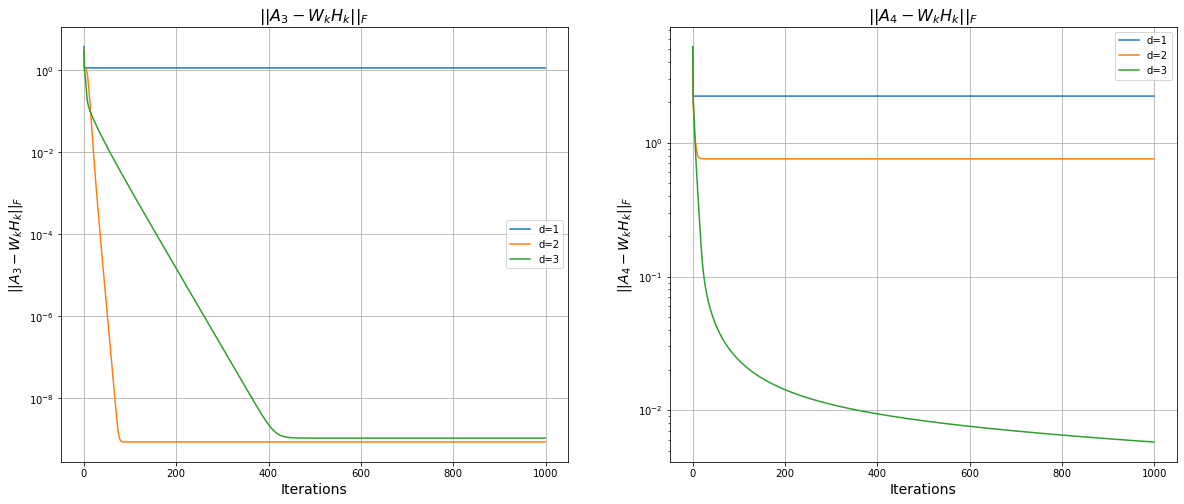

In [122]:
# Using the NMF method to store the data in the matrices A_3 and A_4 for different d values
W_A3_d1, H_A3_d1, norms_A3_d1 = NMF(A_3, 1)
W_A3_d2, H_A3_d2, norms_A3_d2 = NMF(A_3, 2)
W_A3_d3, H_A3_d3, norms_A3_d3 = NMF(A_3, 3)

W_A4_d1, H_A4_d1, norms_A4_d1 = NMF(A_4, 1)
W_A4_d2, H_A4_d2, norms_A4_d2 = NMF(A_4, 2)
W_A4_d3, H_A4_d3, norms_A4_d3 = NMF(A_4, 3)

iterations = np.array(range(0,1000))

# Plotting the error as a function of iterations for the different d values
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes[0].semilogy(iterations, norms_A3_d1)
axes[0].semilogy(iterations, norms_A3_d2)
axes[0].semilogy(iterations, norms_A3_d3)
axes[0].legend(['d=1','d=2', 'd=3'])
axes[0].grid()
axes[0].set_title('$||A_3-W_kH_k||_{F}$', size = 16)
axes[0].set_xlabel('Iterations', size = 14)
axes[0].set_ylabel(r'$||A_3-W_kH_k||_{F}$', size = 14)

axes[1].semilogy(iterations, norms_A4_d1)
axes[1].semilogy(iterations, norms_A4_d2)
axes[1].semilogy(iterations, norms_A4_d3)
axes[1].legend(['d=1','d=2', 'd=3'])
axes[1].grid()
axes[1].set_title('$||A_4-W_kH_k||_{F}$', size = 16)
axes[1].set_xlabel('Iterations', size = 14)
axes[1].set_ylabel(r'$||A_4-W_kH_k||_{F}$', size = 14)

In the plots above we can see how the algorithm converges towards a local minimizer for matrices $A_3$ and $A_4$ with d=1, d=2 and d=3. We can also see that the equation $||A-W_{k+1}H_{k+1}||_{F} ≤ ||A-W_kH_k||_{F}$ is satisfied, as all of the graphs are either constant or decrasing as the number of iterations increases. In addition to convergence, the plots tell us about how accurate the results are. For $A_3$ we can see that while d=1 converges almost straight away, it will yield quite a large error. d=2 and d=3 will both converge towards similar error, but d=2 will converge a lot faster. Therefore d=2 is the best choice for $A_3$. For $A_4$ we get fast convergence for both d=1 and d=2, but d=2 will have a smaller error. d=3 will not converge, so for $A_4$ the best choise of d will be d=2. 

If we run the code with different seeds, we see that the plots for d=2 and d=3 for $A_3$ will look different. This is caused by the fact that the calculations for $A_3$ are highly dependant on the initial conditions of W and H, which are chosen at random. Even though the plots vary, we still get that d=2 gives the best result. This relates to the rank of the matrix, which is 2. The best approximation of the original matrix is achieved with d close to the rank. With d higher than the rank, we will include redundant information, and the norm will take longer to coverge. This is what happens with d=3 in our plots.

__CryptoPunks: An application of NMF__

Up to this point we have been studying NMF for general non-negative matrices. With this knowlegde and implementation we are able to store data from a large matrix in two smaller ones, which save storage. From this point on will use this to store the data from a set of images, CryptoPunks. These images are represented as matrices, and we will therefore be able to use the NMF method. Futhermore we will look at how to reconstruct the data/images based on our saved data. In addition we would like to investigate how good this method is, by comparing the orignal pictures with the reconstructed ones after having used the NMF method. CryptoPunks is a collection of NFTs, which we here are going to represent as 24*24 - matrices with 4 channels (RGBA). 

In [39]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]


In [11]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("pink")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow((scaled_img*255).astype(np.uint8))
        else:
            axes[i,j].imshow((imgs[:,:,:,idx]*255).astype(np.uint8))
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams


Under is an example of $8\cdot 8$ images from CryptoPunks. This is plotted from our original data

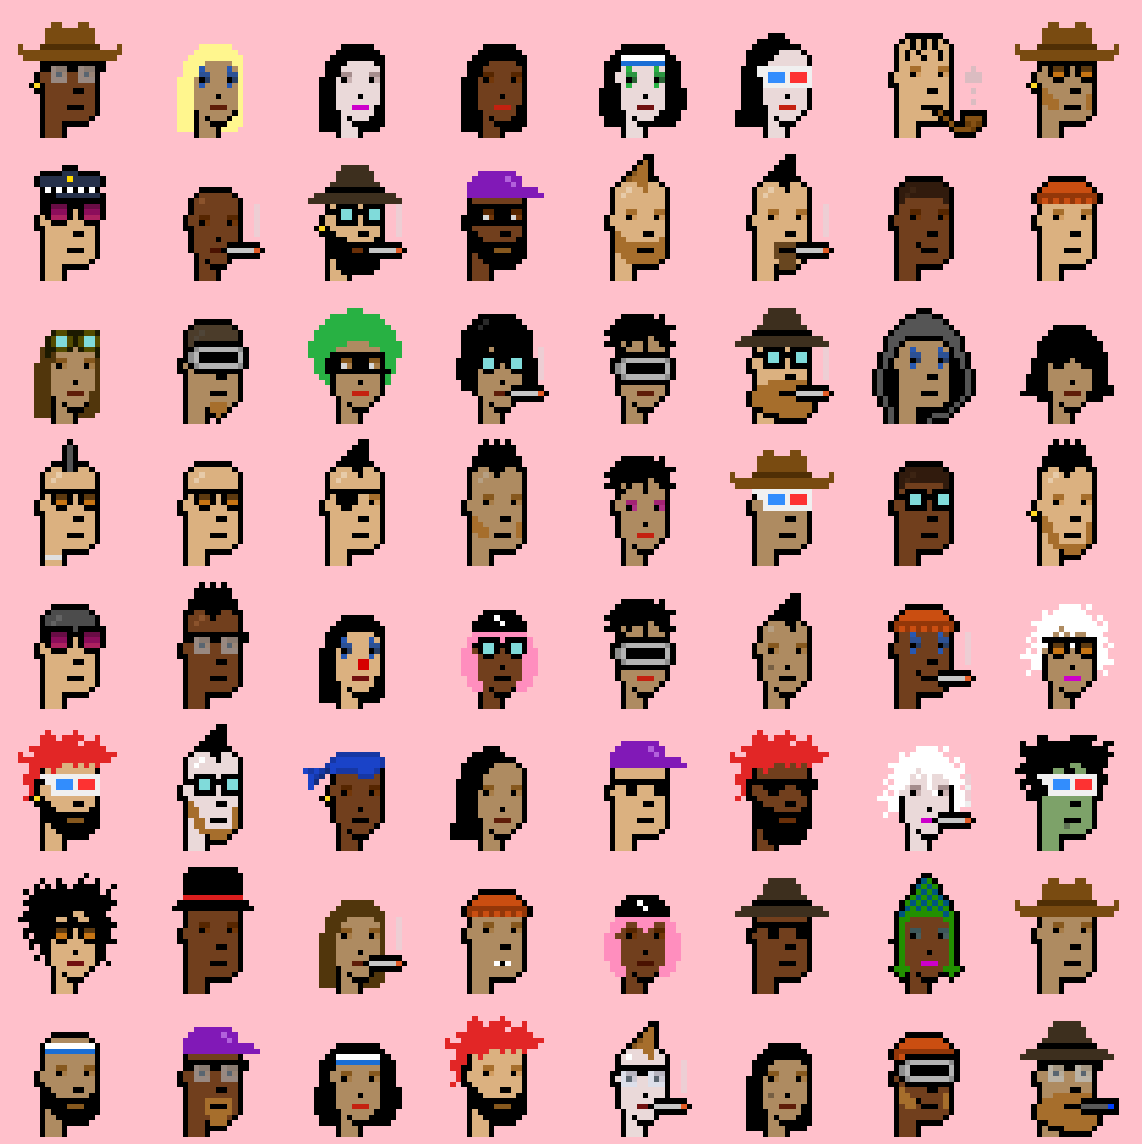

In [12]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

We wish to calculate and plot the mean picture. The mean picture is a 24 * 24 - image where each pixel has the value of the calculated mean from the corresponding pixel from each NFT. 

In the cell below we have divided the data of the matrices, to seperate the RGB channels from the opacity (A) channel. This seperation makes it easier to calculate the mean colour and opacity for each pixel. 

In [22]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

In [29]:
# Empty list of zeros, will be filled to reperesent the meanpicture
mean = np.zeros(shape=(24,24,4))
mean[:,:,0] = np.mean(faces_rgb[:,:,0,:], axis = -1)
mean[:,:,1] = np.mean(faces_rgb[:,:,1,:], axis = -1)
mean[:,:,2] = np.mean(faces_rgb[:,:,2,:], axis = -1)
mean[:,:,3] = np.mean(faces_opacity, axis = -1)

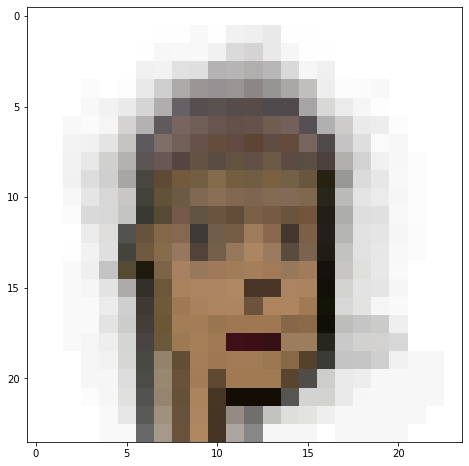

In [38]:
# Plotting the mean image
plt.figure(figsize = (12,8))
plt.imshow(mean)

The image above is the mean image, and does yield some useful information. The image clearly shows a face. We notice that the face is centered, with eyes, nose, mouth and ears as discernible features. The pixels gradually turn more transperant moving outwards from the outline of the face. These more transparent pixels reperesent the accesories, which in a greater extent varies from character to character. 

Some of the pixels seem completely untouched, as we cannot see any colour in several of the pixels. We can check if this is true by counting the number of pixels with zero opacity.

In [37]:
# Counting the pixels with zero opacity
def no_opacity(matrix):
    no_opacity = 0
    for i in range(24):
        for j in range(24):
            if matrix[i][j] == 0:
                no_opacity+=1
    return no_opacity


opacity_matrix = mean[:,:,3]
no_opacity= no_opacity(opacity_matrix)
print(no_opacity)

166


In [40]:
#Use reshape to find the rank
u,s,v=np.linalg.svd(faces_reshaped)  

rank = len(np.where(s>10**(-13))[0])
print(rank)

385


The first of the two codeblock above iterates through the vector for the opacity channel and count the zeros. Since the mean image has 166 clear pixels, none of the CryptoPunk images can have less than 166 clear pixels. It also means these 166 pixels have zero opacity for all of the CryptoPunks.

We have calculated the rank of the matrix containing the images, using the numpy function linalg.svd. As mentioned earlier, the most optimal d for reconstructing the original matrix, is given by the rank. The rank of the matrix containing the images is 385 and the best approximation is thus given by d=385.

In [63]:
# Using the NMF to store the data of the images with d = 64
W_faces_64, H_faces_64, norms_faces_64 = NMF(faces_reshaped, 64, delta = 1e-9, maxiter = 1000, seed = 0)

Given we now have all the implementation necessary to store the image set as smaller matrices, W and H, and plot them, we want to study these matrices. Under we will plot the matrix W from the NMF method, reshaping it to fit as 24 x 24 images. We will look at how different values of d affects the results/plots, and then discuss it. 

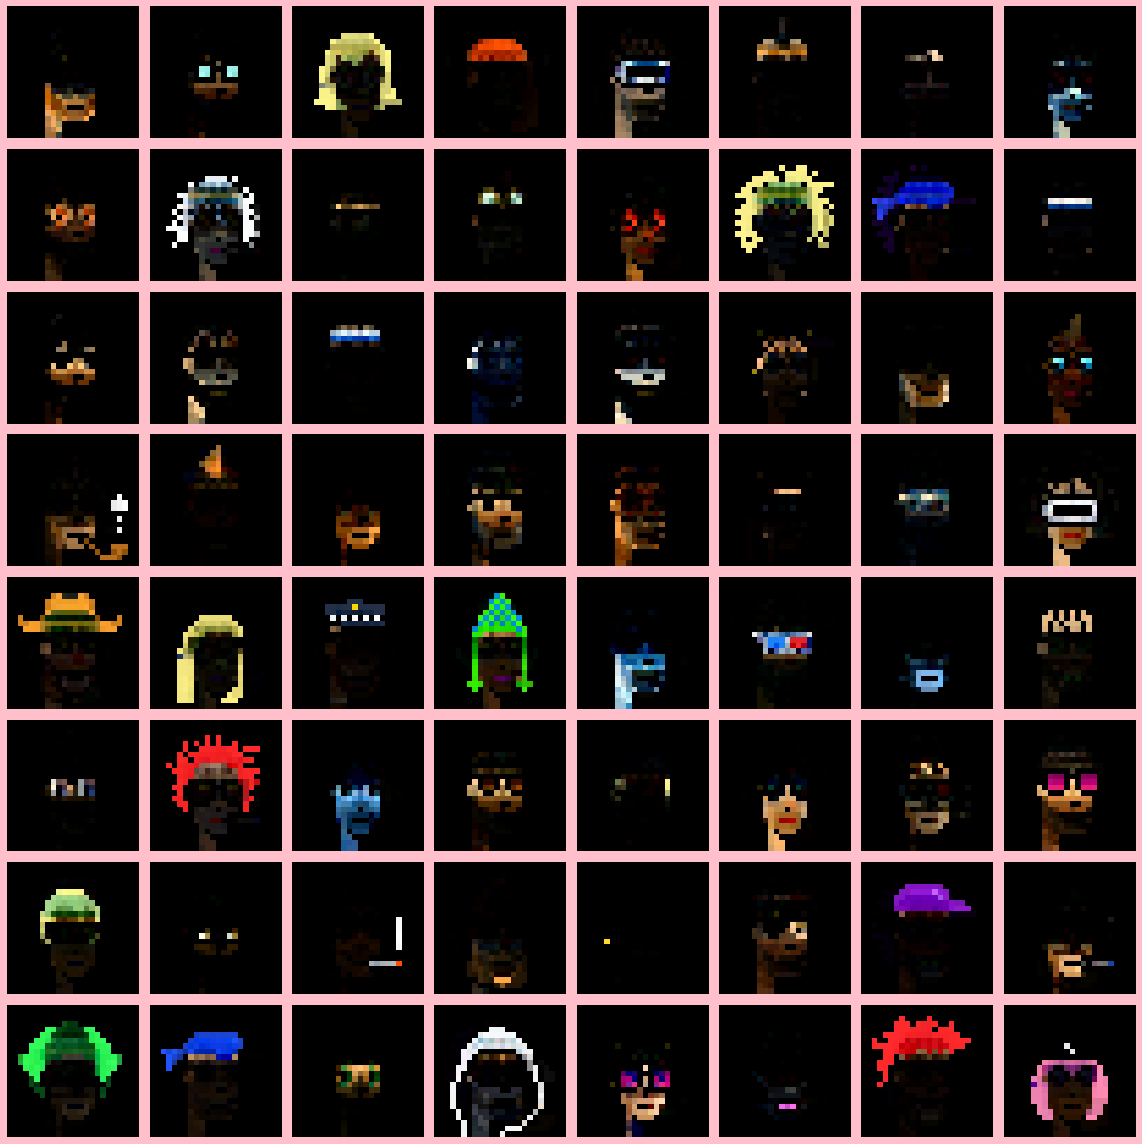

In [64]:
W_faces_reshaped_64 = np.reshape(W_faces_64, (24,24,3,64))
plotimgs(W_faces_reshaped_64, rescale = True)

In [65]:
# Using the NMF to store the data of the images with d = 385
W_faces_385, H_faces_385, norms_faces_385 = NMF(faces_reshaped, 385, delta = 1e-9, maxiter = 1000, seed = 0)

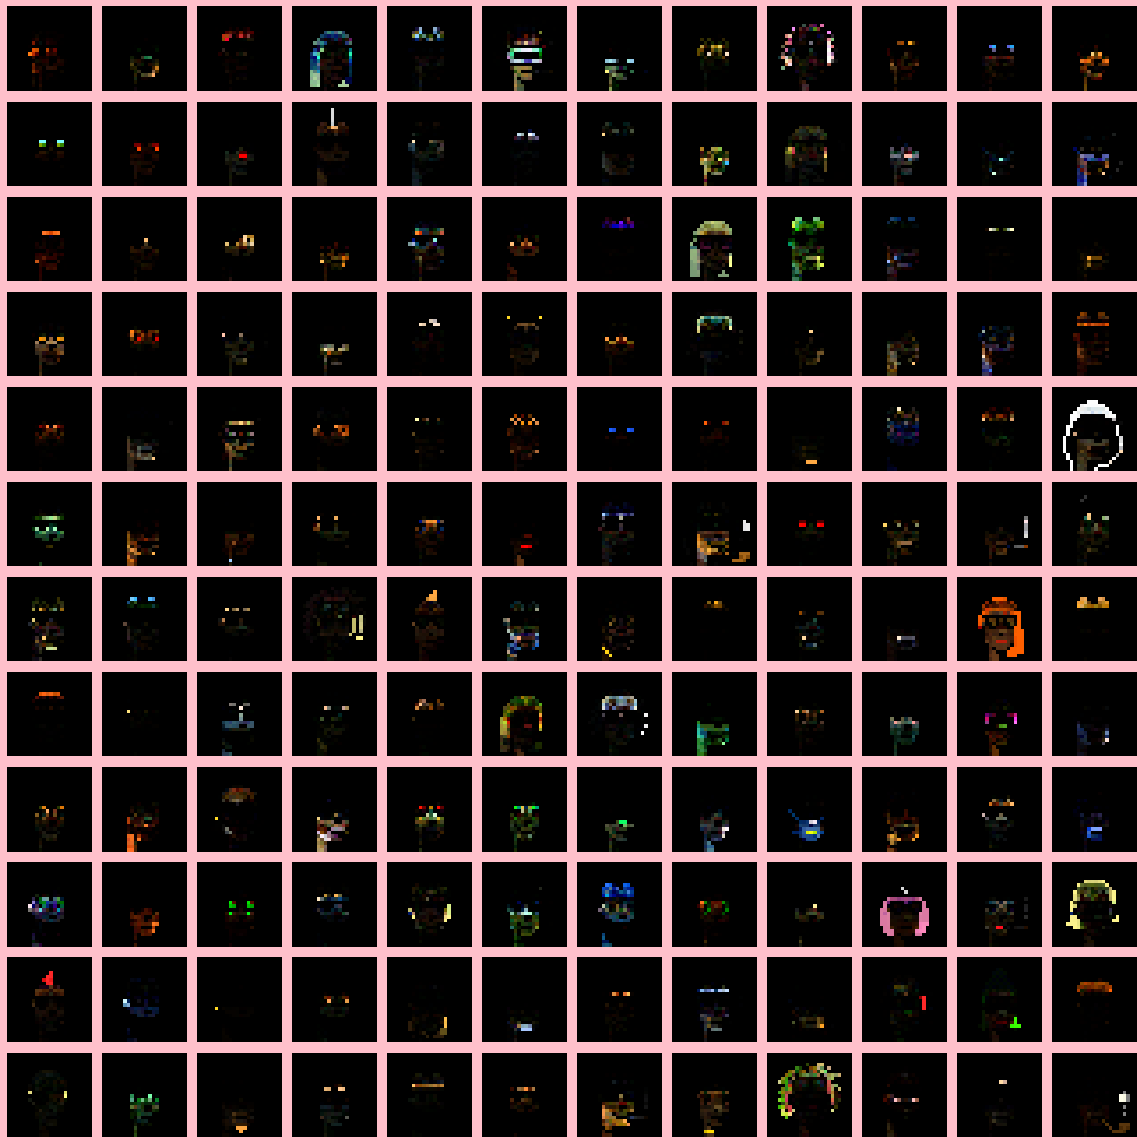

In [66]:
W_faces_reshaped_385 = np.reshape(W_faces_385, (24,24,3,385))
plotimgs(W_faces_reshaped_385, 12,rescale = True)

In [68]:
# Using the NMF to store the data of the images with d = 25
W_faces_25, H_faces_25, norms_faces_25 = NMF(faces_reshaped, 25, delta = 1e-9, maxiter = 1000, seed = 0)

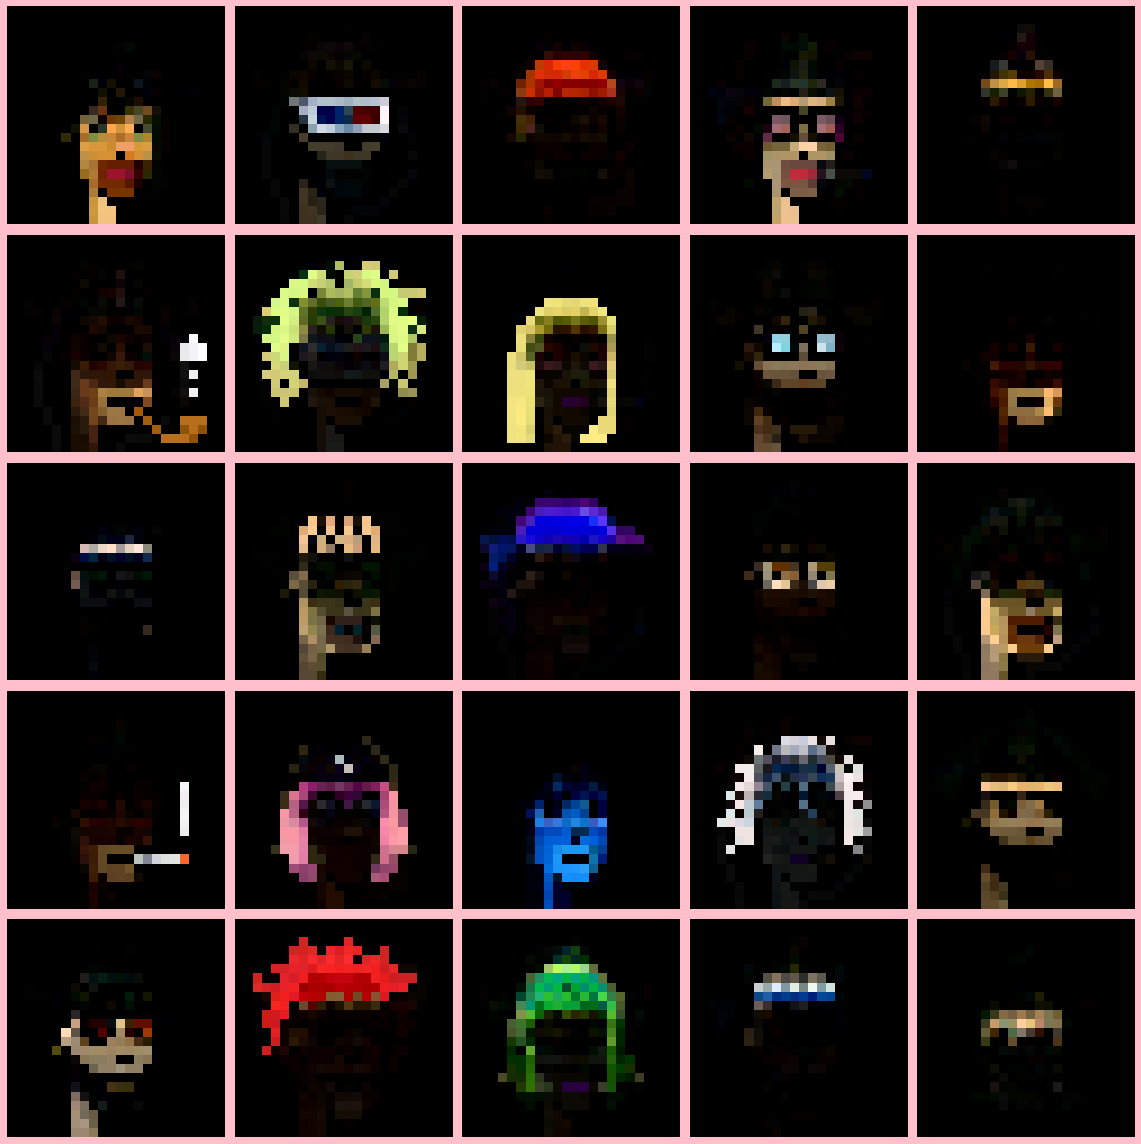

In [69]:
W_faces_reshaped_25 = np.reshape(W_faces_25, (24,24,3,25))
plotimgs(W_faces_reshaped_25, 5,rescale = True)

Above are three plots for the matrix W for different values of d. We have chosen d = 64, d = 385 (the rank) and d = 25. The NMF captures the important features of the dataset. For a larger d we will get a larger W, which will contain more features. For smaller values of d it is harder to seperate the different elements from another. In this case we notice that some of the features are missing. It migth be because the features are too dark for us to distinguish from the background, though it may be the result for dataloss during the NMF method. To conclude, the larger the W the more and more distinct features we will obtain.

In [70]:
# Reconstructing the faces for d = 64
faces_reconstruct_64 = W_faces_64@H_faces_64
faces_reconstruct_64 = np.reshape(faces_reconstruct_64, (24,24,3,500))

Reconstruction for d = 64


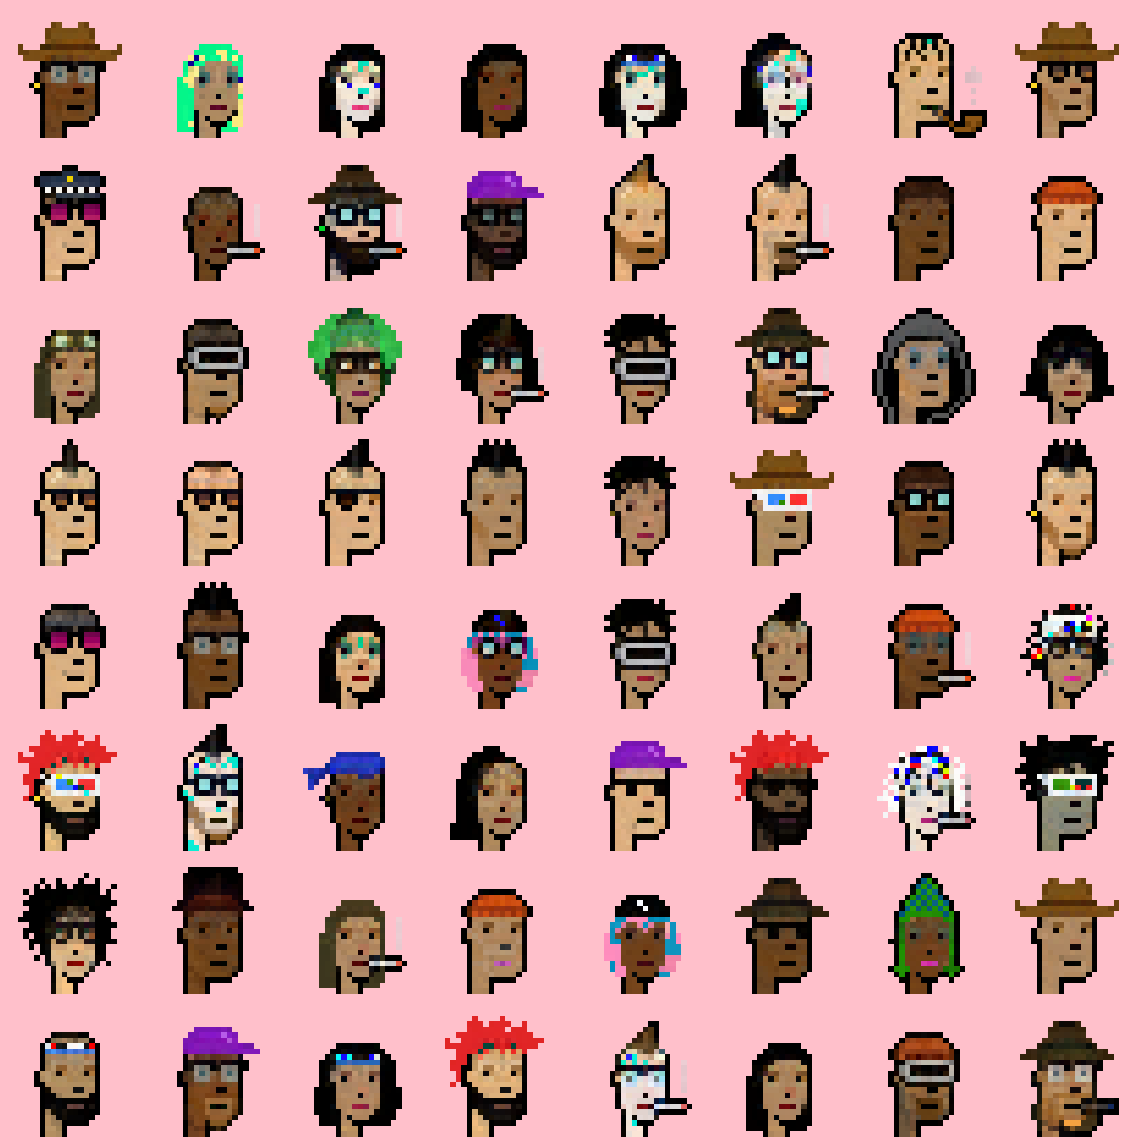

In [78]:
reconstruct_faces_with_opacity_64 = np.zeros(faces.shape)
reconstruct_faces_with_opacity_64[:,:,:3,:] = faces_reconstruct_64
reconstruct_faces_with_opacity_64[:,:,3,:] = faces_opacity
print("Reconstruction for d = 64")
plotimgs(reconstruct_faces_with_opacity_64)

In [72]:
# Reconstructing the faces for d = 385
faces_reconstruct_385 = W_faces_385@H_faces_385
faces_reconstruct_385 = np.reshape(faces_reconstruct_385, (24,24,3,500))

Reconstruction for d = 385


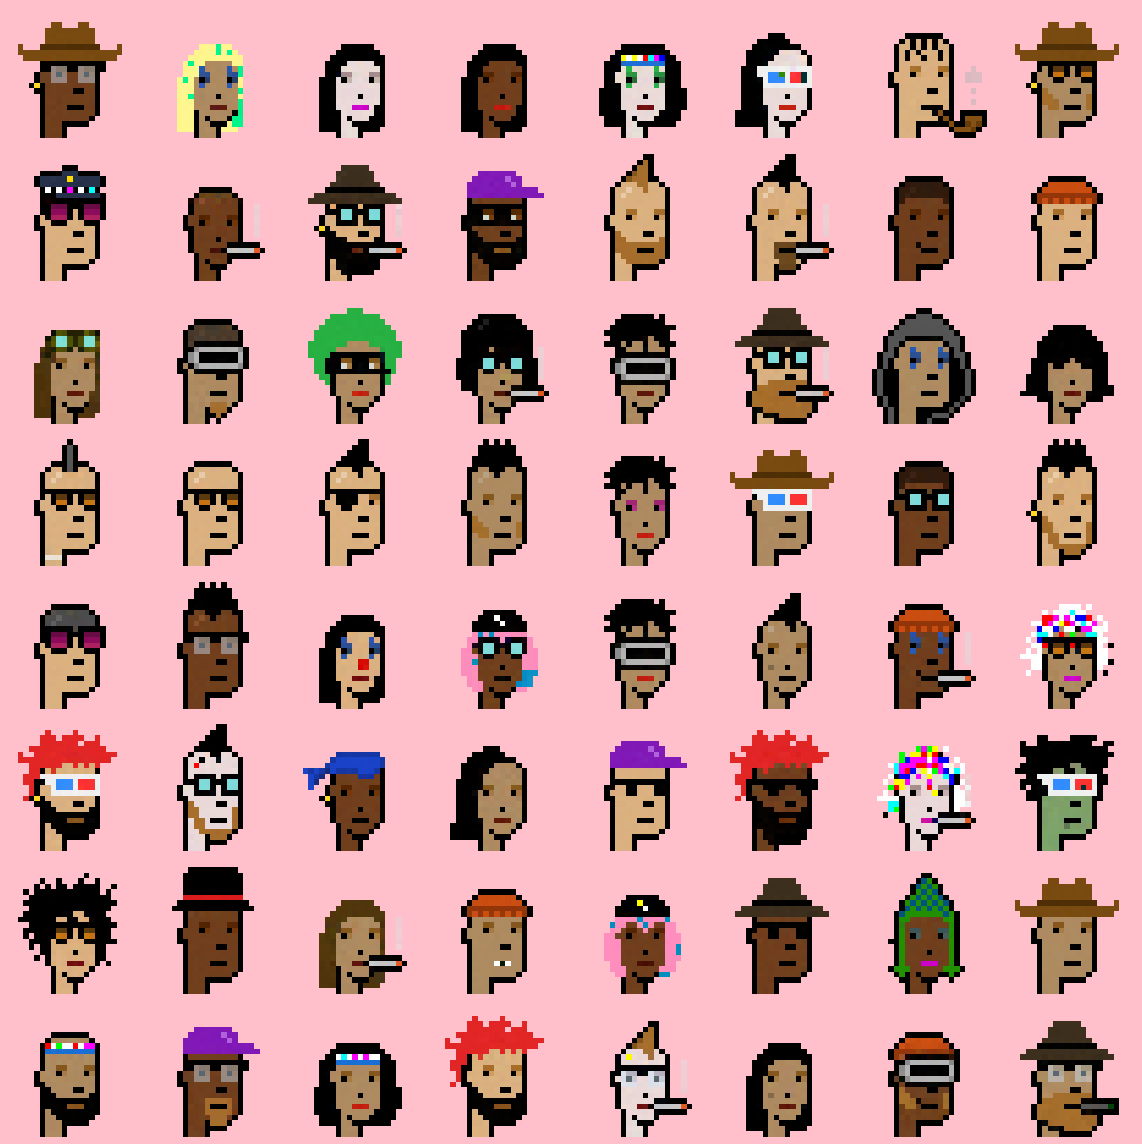

In [77]:
reconstruct_faces_with_opacity_385 = np.zeros(faces.shape)
reconstruct_faces_with_opacity_385[:,:,:3,:] = faces_reconstruct_385
reconstruct_faces_with_opacity_385[:,:,3,:] = faces_opacity
print("Reconstruction for d = 385")
plotimgs(reconstruct_faces_with_opacity_385)

In [75]:
# Reconstructing the faces for d = 25
faces_reconstruct_25 = W_faces_25@H_faces_25
faces_reconstruct_25 = np.reshape(faces_reconstruct_25, (24,24,3,500))

Reconstruction for d = 25


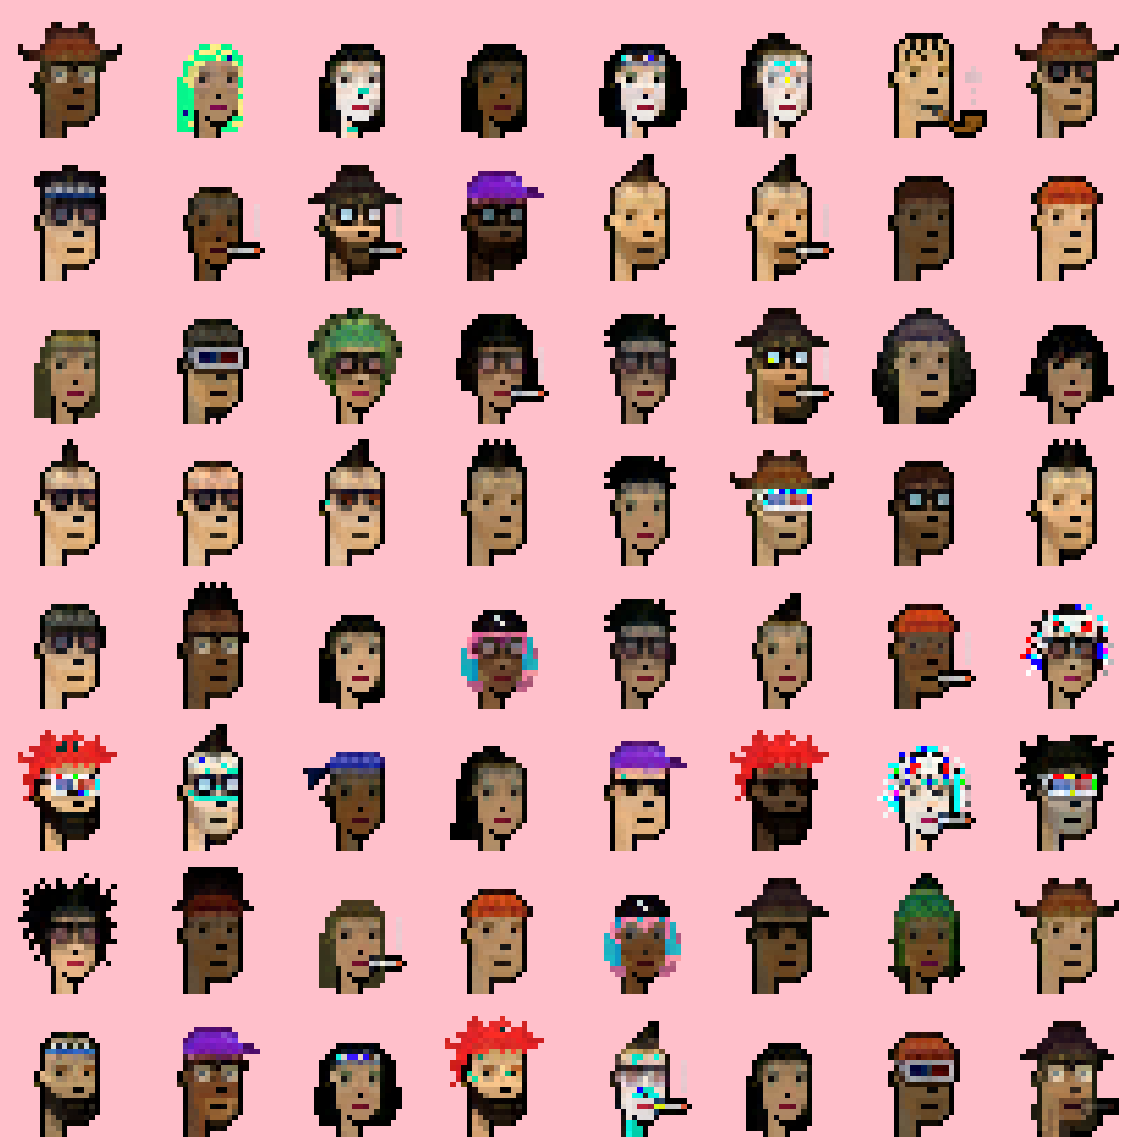

In [79]:
reconstruct_faces_with_opacity_25 = np.zeros(faces.shape)
reconstruct_faces_with_opacity_25[:,:,:3,:] = faces_reconstruct_25
reconstruct_faces_with_opacity_25[:,:,3,:] = faces_opacity
print("Reconstruction for d = 25")
plotimgs(reconstruct_faces_with_opacity_25)

Over are three plot of the recontructed images after use of NMF, with different d values. The reconstructions are overall good, but they do deviate a bit from the original images. There are some exceptions where the images deviate a lot from the original, but the images only deviate in term of colour, and not shape. How much the images deviate depends on the values of d. The best reconstructions comes from the larger value of d. The images appear more pixelated, for d = 25 and d = 64. This is caused by a colour change in some of the pixels. For darker colours there is only a slight change, while the lighter colours have a more drastic change. The change in RGB values are not necessarily greater for the lighter colours than the darker colours, as the differences in pixel values can be small even though we perceive a great change. Not all features are equally well reconstructed. The general facial features such as mouth, nose, eyes and ears are almost perfectly reconstructed, as well as shape of the head. It appears that the reconstruction of the accesories deviate more for the original images, than the features previously mentioned.
The different values of d gives a significant difference in the reconstructed images. Whilest d = 385 gives a almost perfect reconstruction, the reconstruction from the lower d values deviates a lot more. There are also a difference between the reconstructions from d = 25 and d = 64, where the latter is more accurate. 

When it comes to runtime, the NMF uses more time for a larger value of d. The runtime for d = 385 is significantly larger than for d = 25 and d = 64. In our situation the difference in runtime will not make a huge difference, but this might be the case for greater sets of data. Seen as the reconstruction with d = 385 is so much better than for the lower values of d, as well as the difference in runtime is not a huge factor, using d = 385 will definitely be worth it. Though using such a large value for d will take up much storage, which is exactly what we are trying to avoid. Seen as d = 64 will take up much less storage, and still create a decent reconstruction of the original images, using this value for d would be most beneficial. Below are calculations for memory used for the different scenarios. From these calculation we can confirm that the NMF method saves memory space. 

In [120]:
# Calculating the memory used for storage of data before and after the NMF method, with different values d
print("Memory used for original matrix: ", faces_reshaped.nbytes, "bytes")

Wbytes64=W_faces_64.nbytes
Hbytes64=H_faces_64.nbytes

Wbytes385=W_faces_385.nbytes
Hbytes385=H_faces_385.nbytes

print("Memory used for matrices with d = 64: ",Wbytes64+Hbytes64, "bytes")
print("Memory used for matrices with d = 385 (rank): ",Wbytes385+Hbytes385, "bytes")

Memory used for original matrix:  6912000 bytes
Memory used for matrices with d = 64:  1140736 bytes
Memory used for matrices with d = 385 (rank):  6862240 bytes


In [21]:
# Uses the NMF method to store the data for different d values
W_faces_d16, H_faces_d16, norms_faces_d16 = NMF(faces_reshaped, 16)
W_faces_d32, H_faces_d32, norms_faces_d32 = NMF(faces_reshaped, 32)
W_faces_d64, H_faces_d64, norms_faces_d64 = NMF(faces_reshaped, 64)

iterations = np.array(range(0,1000))

Text(0, 0.5, '$||A-W_kH_k||_{F}$')

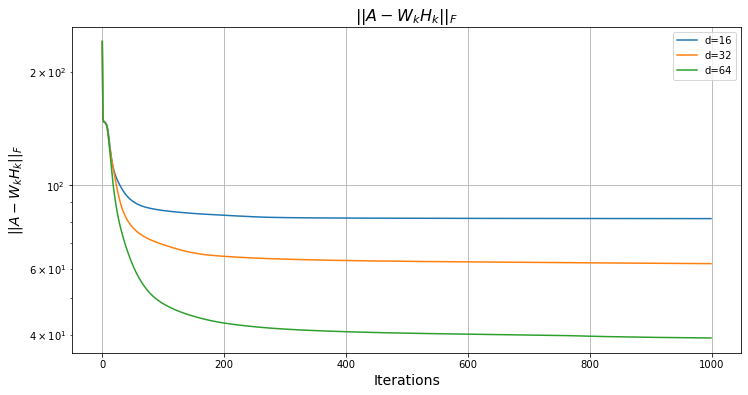

In [43]:
# Plotting the norm as a function of iterations
plt.figure(figsize=(12, 6))
plt.semilogy(iterations, norms_faces_d16)
plt.semilogy(iterations, norms_faces_d32)
plt.semilogy(iterations, norms_faces_d64)
plt.legend(['d=16','d=32', 'd=64'])
plt.grid()
plt.title('$||A-W_kH_k||_{F}$', size = 16)
plt.xlabel('Iterations', size = 14)
plt.ylabel(r'$||A-W_kH_k||_{F}$', size = 14)


Over is a plot of $||A-W_kH_k||_{F}$ as a function of iterations, for d=16, d=32 and d=64. It looks like the algorithm has converged for the different d-values, and the error gets smaller as d increases. This is reasonable as we have a matrix of rank 385, so the error should grow smaller as d gets closer to the rank. 

In [44]:
# Uses the NMF method to store the data for different d values
W_faces_d128, H_faces_d128, norms_faces_d128 = NMF(faces_reshaped, 128)
W_faces_d256, H_faces_d256, norms_faces_d256 = NMF(faces_reshaped, 256)
norms_list = np.array([norms_faces_d16[-1], norms_faces_d32[-1], norms_faces_d64[-1], norms_faces_d128[-1], norms_faces_d256[-1]], norms_faces_385)
list_of_d = np.array([16,32,64,128,256])

Text(0, 0.5, '$||A-WH||_{F}$')

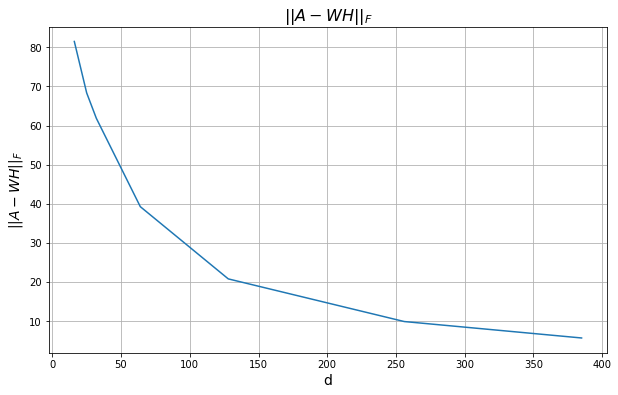

In [123]:
norms_list = np.array([norms_faces_d16[-1],norms_faces_25[-1], norms_faces_d32[-1], norms_faces_d64[-1], norms_faces_d128[-1], norms_faces_d256[-1], norms_faces_385[-1]])
list_of_d = np.array([16,25,32,64,128,256,385])

# Pltting the final norm for different d values 
plt.figure(figsize=(10, 6))
plt.plot(list_of_d, norms_list)
plt.grid()
plt.title('$||A-WH||_{F}$', size = 16)
plt.xlabel('d', size = 14)
plt.ylabel(r'$||A-WH||_{F}$', size = 14)

The plot above shows $||A-WH||_{F}$ as a function of d. We have chosen to use the following values of d, 16, 25, 32, 64, 128, 256 and 385, where some are reused from previous calculation. We can clearly see that the error gets smaller as d increases. This corresponds with the idea that the NMF gives a better approximation to A as d increases up to the rank of A, which here is 385. When d is low, there will not be enough columns to cover all of the information from the images, which yield a greater error.

__Denoising : How to use NMF to improve picture quality__

The restored images we have looked at, all had deviations from the original images. This is called image noise, characterized by the presence of random variations of colour and brightness that did not exist in the original image. Noise is very common in image processing and when a picture is taken there is nearly always some degree of noise. For physical images the noise mainly follows a Gaussian distribution model. (Wikipedia, 2022)

One advantage of the NMF method is that it can be used to reduce image noise, called denoising. Since W does not contain as much information as the original matrix A, a lot of the noise is reduced. W does however contain more information for greater values of d. Reconstruction error will therfore be greater for both too small and too big values of d. We want to look at how the NMF method can be used for denoising and to what extent it is actually useful. For this we will add gaussian noise to the original CryptoPunks. Then we will pass the image through the NMF function before plotting it.

In [86]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces



$||A_{noisy}-A||_{F} = $ 41.89045590225989


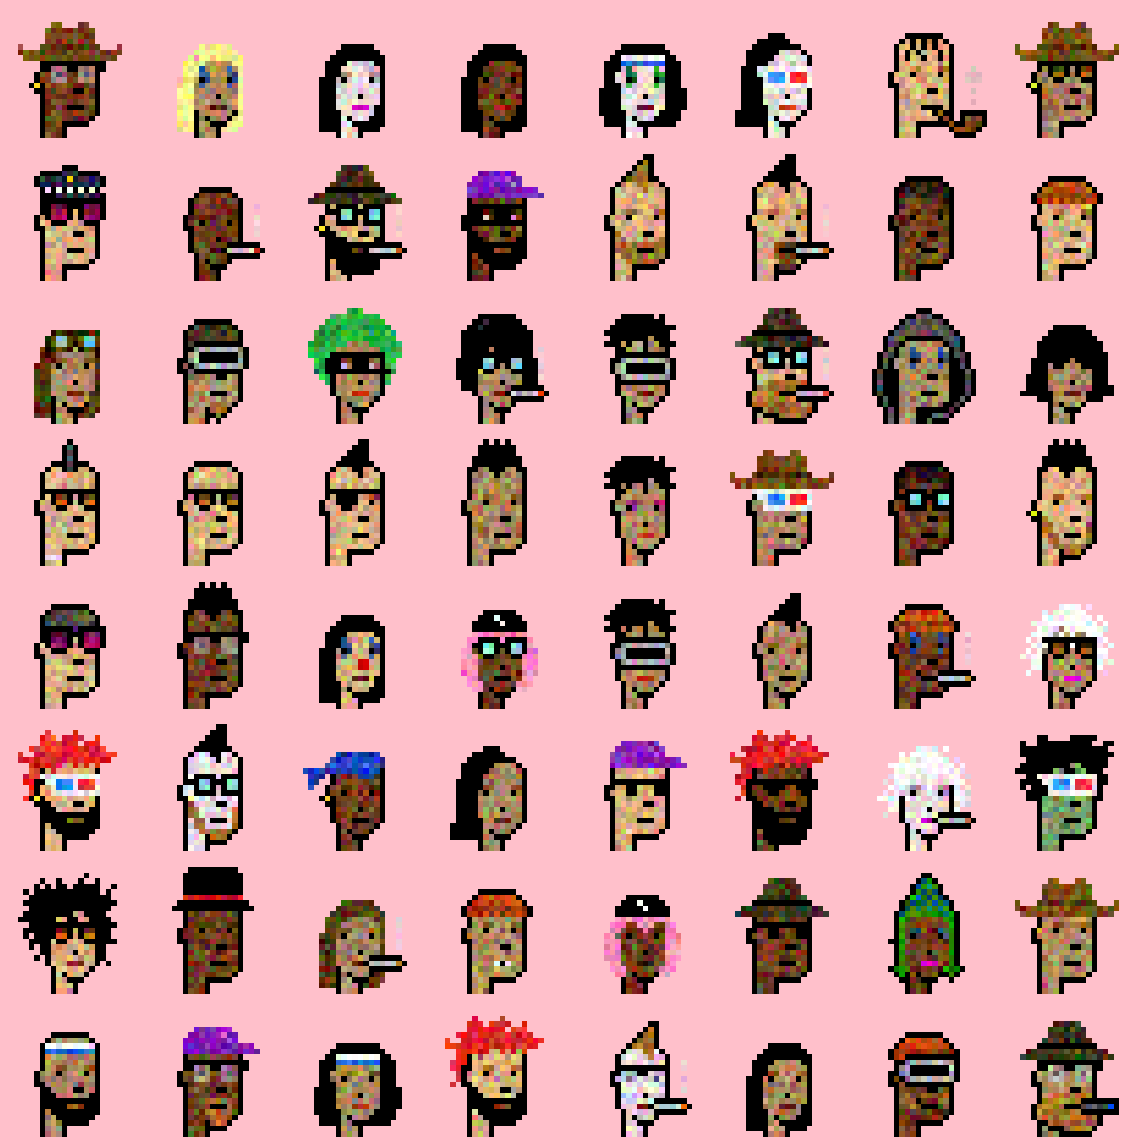

In [113]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print('$||A_{noisy}-A||_{F} = $',noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity)

In [88]:
W_noisyfaces_64, H_noisyfaces_64, norms_noisyfaces_64 = NMF(noisy_faces, 64, delta = 1e-9, maxiter = 1000, seed = 0)
W_noisyfaces_reshaped_64 = np.reshape(W_noisyfaces_64, (24,24,3,64))

The noisy features with d = 64


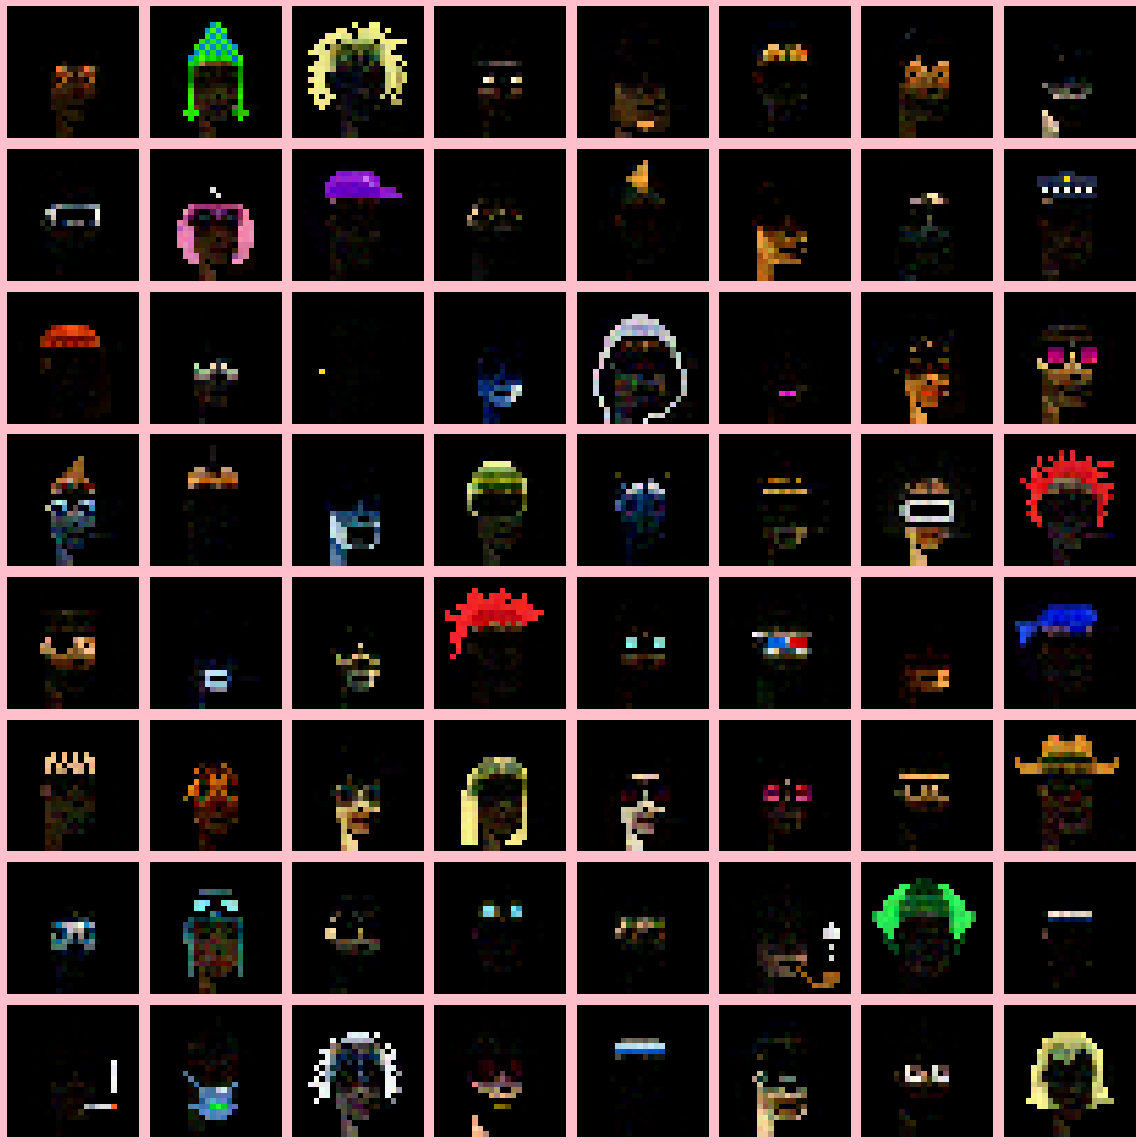

In [107]:
W_noisyfaces_reshaped_64 = np.reshape(W_noisyfaces_64, (24,24,3,64))
print("The noisy features with d = 64")
plotimgs(W_noisyfaces_reshaped_64, rescale = True)

In [92]:
noisyfaces_reconstruct_64 = W_noisyfaces_64@H_noisyfaces_64
noisyfaces_reconstruct_64 = np.reshape(noisyfaces_reconstruct_64, (24,24,3,500))

Reconstruction for noisy d = 64


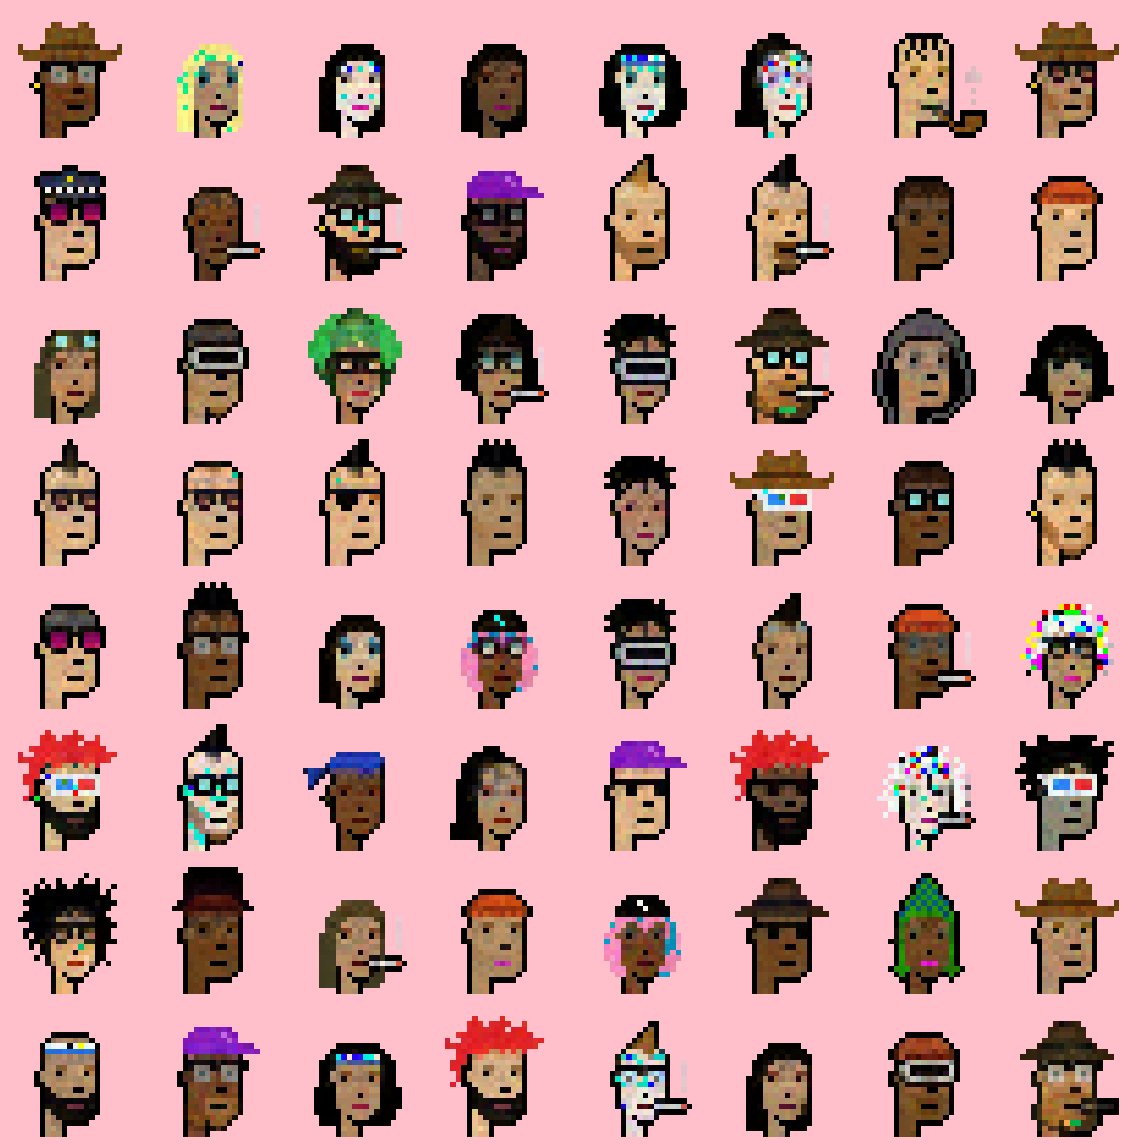

In [96]:
reconstruct_noisyfaces_with_opacity_64 = np.zeros(faces.shape)
reconstruct_noisyfaces_with_opacity_64[:,:,:3,:] = noisyfaces_reconstruct_64.reshape(faces_rgb.shape)
reconstruct_noisyfaces_with_opacity_64[:,:,3,:] = faces_opacity
print("Reconstruction for noisy d = 64")
plotimgs(reconstruct_noisyfaces_with_opacity_64)


The reconstruction we get after using the NMF method are less noisy than the noisy images we started with. There is still some noise, but to a much smaller extent. As in the case without noise the reconstruction are pixelated, they do however deviate more from the original images than the case without noise. The features, W, is plotted above the reconstruction, and appear much less pixelated than in the noisy images. Though if we where to compare the noisy features with the non-noisy features we find that the noisy features are more pixelated. Previous inspection has shown that for a d value equal to the rank the data will be stored in a way most ideal for reconstruction. Therefore we would like to investigate how this value of d will help denoising the images. 

In [98]:
W_noisyfaces_385, H_noisyfaces_385, norms_noisyfaces_385 = NMF(noisy_faces, 385, delta = 1e-9, maxiter = 1000, seed = 0)
W_noisyfaces_reshaped_385 = np.reshape(W_noisyfaces_385, (24,24,3,385))

The noisy features with d = 385


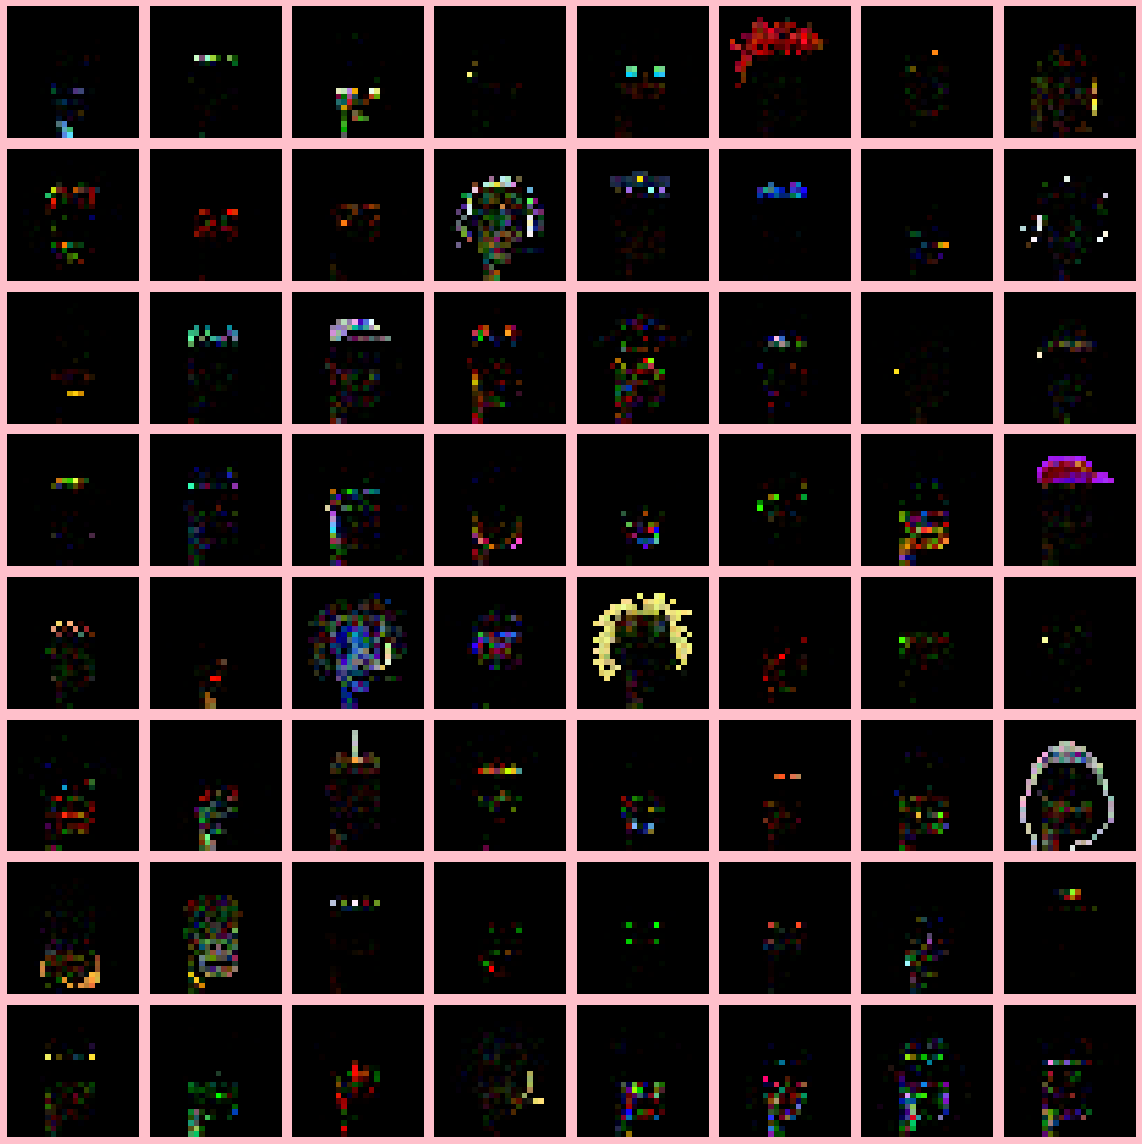

In [106]:
W_noisyfaces_reshaped_385 = np.reshape(W_noisyfaces_385, (24,24,3,385))
print("The noisy features with d = 385")
plotimgs(W_noisyfaces_reshaped_385, rescale = True)

In [101]:
noisyfaces_reconstruct_385 = W_noisyfaces_385@H_noisyfaces_385
noisyfaces_reconstruct_385 = np.reshape(noisyfaces_reconstruct_385, (24,24,3,500))

Reconstruction for noisy d = 385


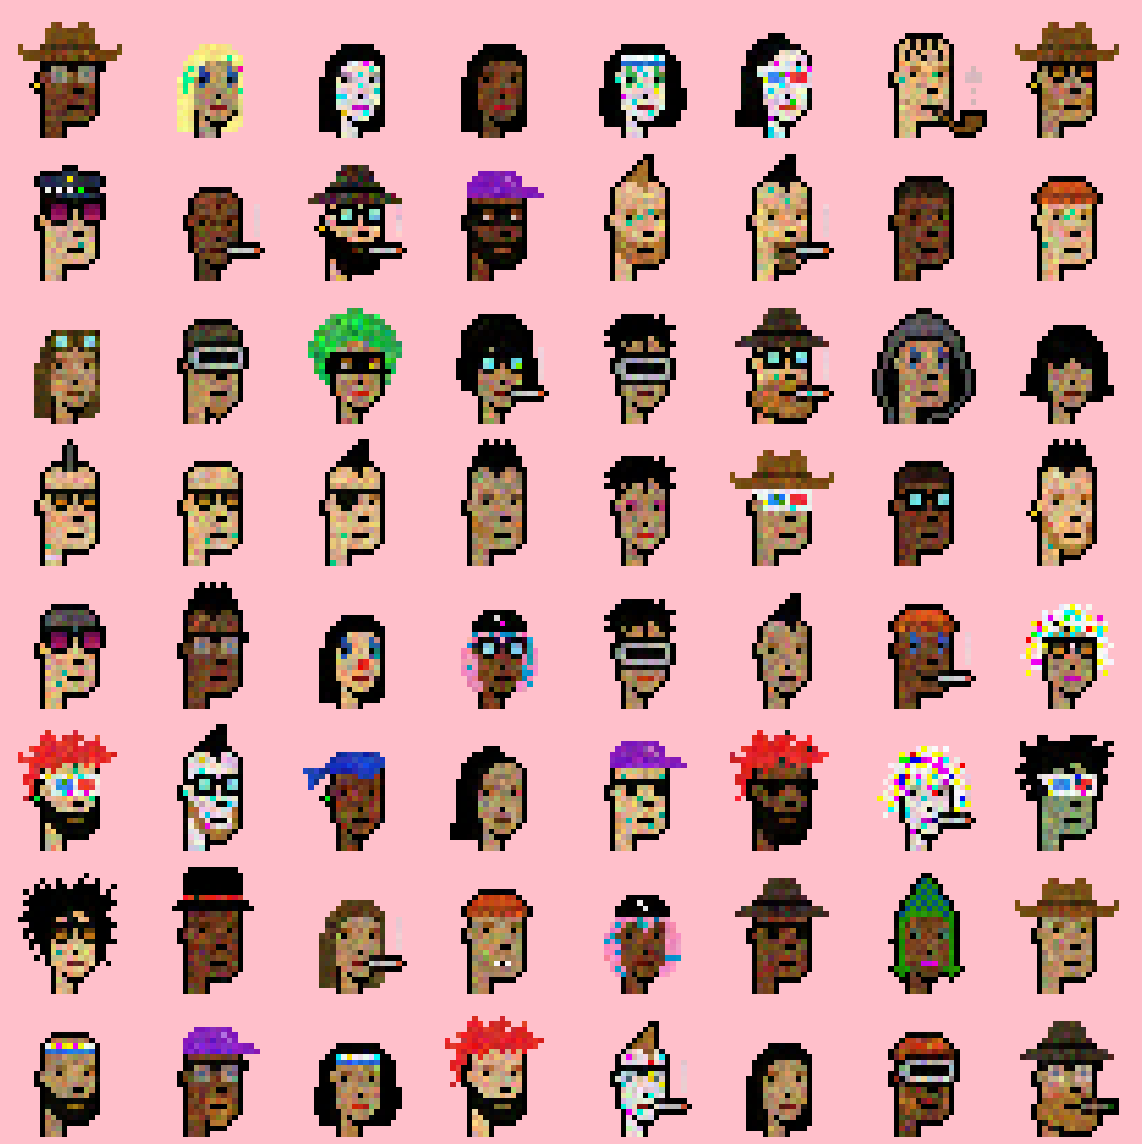

In [114]:
reconstruct_noisyfaces_with_opacity_385 = np.zeros(faces.shape)
reconstruct_noisyfaces_with_opacity_385[:,:,:3,:] = noisyfaces_reconstruct_385.reshape(faces_rgb.shape)
reconstruct_noisyfaces_with_opacity_385[:,:,3,:] = faces_opacity
print("Reconstruction for noisy d = 385")
plotimgs(reconstruct_noisyfaces_with_opacity_385)

When we tried to reconstruct the images after using the NMF method with d = 385 we noticed that we were not able to remove the noise. We know that the purpose of the NMF method is to store data, and that a higher value of d gives a higher accuracy. For high values of d our matrices will store data about the noise, and therfore this noise will be included in the reconstructions. In our case with d = 385 we therefore store a lot of information about the noise, which can be seen in the image above. Although we do not want the d values to be to high, we also do not want them to be too low. Too low d values will not be able to contain adequate amouts of data. The ideal value of d will therefore lay somewhere in the middle.  

In [115]:
#calculating more noiseless norm values for different d values
W_faces_d200, H_faces_d200, norms_faces_d200 = NMF(faces_reshaped, 200)
W_faces_d400, H_faces_d400, norms_faces_d400 = NMF(faces_reshaped, 400)

noiseless_norms = np.array([norms_faces_d16[-1], norms_faces_d32[-1], norms_faces_d64[-1], norms_faces_d128[-1], norms_faces_d200[-1], norms_faces_d256[-1], norms_faces_385[-1], norms_faces_d400[-1]])
                            

In [116]:
#calculating noisy norm values for the diffent d values
def noisy_norms(A, A_noisy, d):
    #A: matrix for the original images
    #A_noisy: matrix for the original images
    #d = list of d-values
    noisy_norms = np.zeros([len(d)])
    for i in range(len(d)):
        W, H, n = NMF(A_noisy, d[i])
        noisy_norms[i] = np.linalg.norm(A-np.dot(W,H), ord = 'fro')
    return noisy_norms

d_values = np.array([16, 32, 64, 128, 200, 256, 385, 400])
noisy_norms = noisy_norms(faces_reshaped, noisy_faces, d_values)

Text(0, 0.5, '$||A-WH||_{F}$')

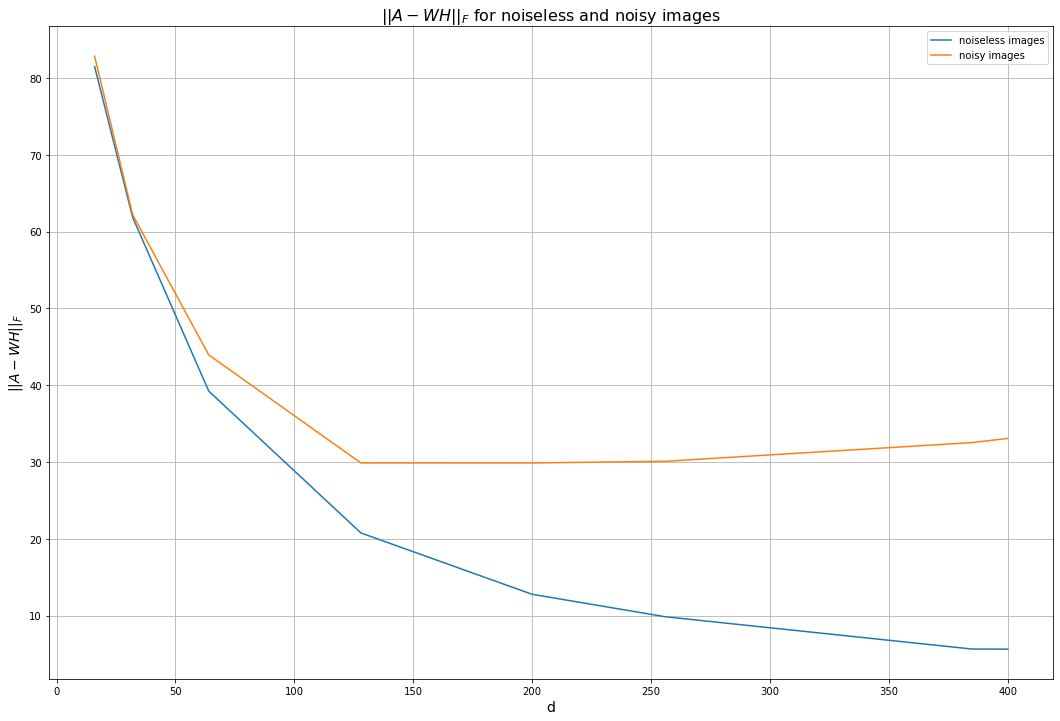

In [118]:
#plotting both the noisy and the noiseless norms for the same d-values
plt.figure(figsize=(18, 12))
plt.plot(d_values, noiseless_norms)
plt.plot(d_values, noisy_norms)
plt.legend(['noiseless images', 'noisy images'])
plt.grid()
plt.title('$||A-WH||_{F}$ for noiseless and noisy images', size = 16)
plt.xlabel('d', size = 14)
plt.ylabel(r'$||A-WH||_{F}$', size = 14)

The plot above shows $||A-WH||_{F}$ as a function of d for both noisy and noiseless images. We can see that the graph for the noiseless image only decreases as d increases. The graph for the noisy image will decrease to a certain d value, and then start to increase. This is due to something called underfitting and overfitting. For high values of d, the colums of W will be able to fit more information, and therefore contain more of the noise in the image. Therefore, the reconstruction will turn out noisy as well. This is overfitting, and causes the difference between the original (noiseless) image and the reconstruction to increase. The opposite is underfitting, which happens for lower d values. Here the model will contain less noise, as W will have fewer columns, but this also causes loss of other information for the reconstruction. This is similar to what happens for the noiseless images. We can see that the best choice of d for the noisy images will be around d = 200, as this gives the lowest difference.

__Conclusion__

The Non-negative Matrix factorization method, NMF, has been very useful for reducing storage and noise for the NFTs CryptoPunks looked at in this project. However, we were not able to reconstruct the images to be identical to the originals. Even though we were able to save storage, we lost some of the information needed to accurately plot the images. Overall, the reconstructions were good, and the method will defintiely be good enough for most cases. The runtime did become longer the more accurate we wanted the images to be. It is therefore not a good method if it is important to have an accurate copy of the original image or if shorter runtime is more important than using less memory. We found one big advantage of the method to be denoising, as the method was able to remove a very good part of the noise. Especially for denoising purposes, the choice of d was very important to actually reduce noise. A value too low would result in more added noise and a value too big would result in more kept noise.

__Bibliography__

Ludvigsen, M. (2022, March 28). Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization. Hentet fra TMA4320 vår 2022 - Industriell Matematikk-Prosjekt: https://wiki.math.ntnu.no/_media/tma4320/2022v/tma4320_indmat_prosjekt_2022-2.pdf

Wikipedia. (2022, MArch 30). Image noise. Hentet April 1, 2022 fra Wikipedia: https://en.wikipedia.org/wiki/Image_noise

Witman, E. (2021, March 15). How much RAM do I need? Why having enough RAM is important, and how to tell how much your computer needs. Hentet fra INSIDER: https://www.businessinsider.com/how-much-ram-do-i-need?r=US&IR=T#:~:text=8%20GB%20is%20the%20standard,memory%20sticks%22%20in%20your%20computer.
